Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified: 07/06/23\
DSI

In [1]:
import sys
sys.path.append('..')

import pandas as pd
# from utils.clean_data import rename_columns, translate_column
from utils.get_data import get_data
from utils.record_linkage import find_matches
from utils.plot import cargo_grouping, plot_line, plot_crops

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
ig = get_data("ig_kernel_10000.csv", "ig")
bsgi = get_data("bsgi_outbound_shipments.csv", "bsgi")

,product,corn,sunflower
0,"олії соняшникова, сафлорова або бавовняна та ї...",False,True
1,"олії соняшникова, сафлорова або бавовняна та ї...",False,True
2,солі та гідроксиди амонію четвертинні; лецитин...,False,False
3,"олії соняшникова, сафлорова або бавовняна та ї...",False,True
4,"олії соняшникова, сафлорова або бавовняна та ї...",False,True
...,...,...,...
9995,"олії соняшникова, сафлорова або бавовняна та ї...",False,True
9996,"макуха та інші тверді відходи і залишки, одерж...",False,True
9997,"макуха та інші тверді відходи і залишки, одерж...",False,True
9998,"макуха та інші тверді відходи і залишки, одерж...",False,True


In [17]:
# EXPORTS TIME SERIES
# We first have to translate the "PRODUCT" column with the deep_translator API
kernel_c = kernel.copy()
translate_column(kernel_c, "product", "google")
translate_column(kernel_c, "product", "deepl")

In [18]:
kernel_c["same_translation"] = kernel_c["product_gt"] == kernel_c["product_deepl"]

# Check how similar were the translations
print("How many rows were translated the same? ", sum(kernel_c["same_translation"]))
print("Different translations:\n", kernel_c[["product_gt", "product_deepl", "same_translation"]].head())

How many rows were translated the same?  2
Different translations:
                                           product_gt  \
0  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
1  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
2  QUATERNARY AMMONIUM SALTS AND HYDROXIDES; LECI...   
3  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   
4  SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...   

                                       product_deepl  same_translation  
0  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
1  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
2  QUATERNARY AMMONIUM SALTS AND HYDROXIDES; LECI...             False  
3  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  
4  SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...             False  


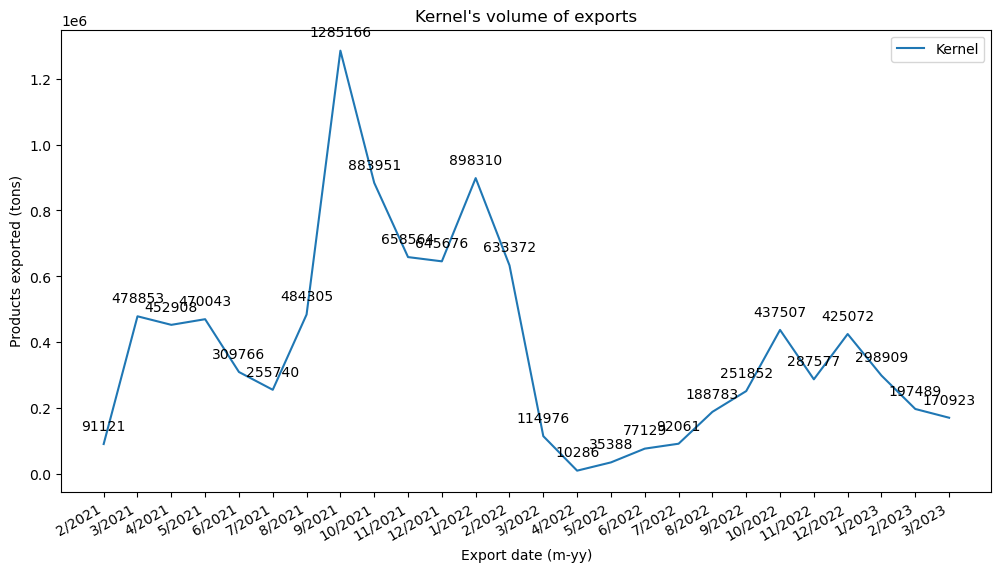

In [19]:
kernel_c["year"] = kernel_c["export_date"].dt.year
kernel_c["month"] = kernel_c["export_date"].dt.month
kernel_c["weight_ton"] = kernel_c["weight_kg"] / 1000

kernel_g = cargo_grouping(kernel_c, ["year", "month"], ["weight_ton"], ["year", "month"], True)
kernel_g["date"] = kernel_g["month"].astype(str) + "/" + kernel_g["year"].astype(str)
plot_line(kernel_g["date"], [kernel_g["weight_ton"]], ["Kernel"], "Kernel's volume of exports", "Export date (m-yy)", "Products exported (tons)")

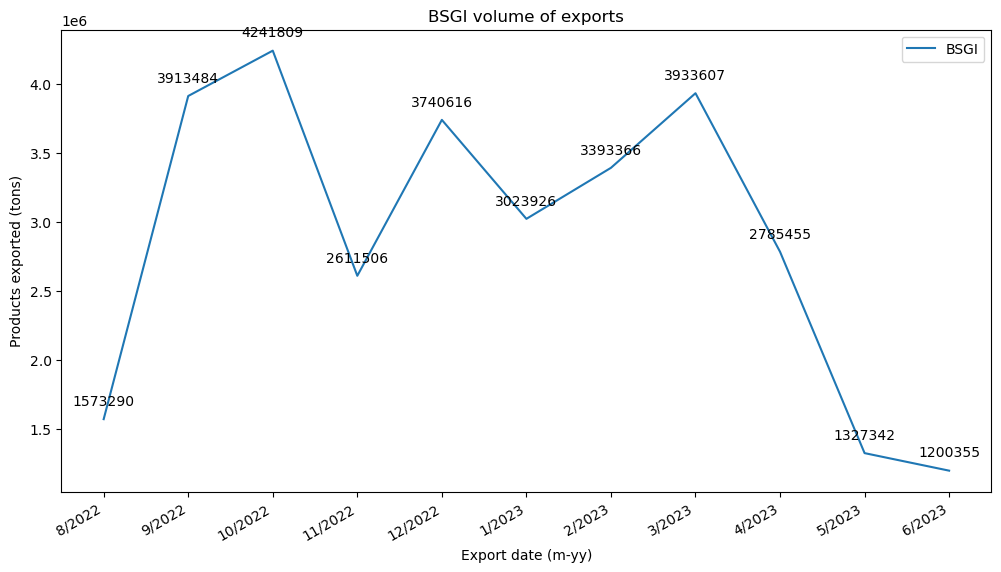

In [21]:
# Compare Kernel's exports with overall exports in the Black Sea ports from Black Sea Grain Initiative

outbound = pd.read_csv("../data/bsgi_outbound_shipments.csv", thousands=",", parse_dates=["Departure date"])
outbound = rename_columns(outbound)

outbound["year"] = outbound["departure_date"].dt.year
outbound["month"] = outbound["departure_date"].dt.month
outbound = outbound.rename(columns={"metric_tons": "weight_ton"})

outbound_g = cargo_grouping(outbound, ["year", "month"], ["weight_ton"], ["year", "month"], True)
outbound_g["date"] = outbound_g["month"].astype(str) + "/" + outbound_g["year"].astype(str)
plot_line(outbound_g["date"], [outbound_g["weight_ton"]], ["BSGI"], "BSGI volume of exports", "Export date (m-yy)", "Products exported (tons)")


IG columns:
 Index(['year', 'month', 'weight_ton', 'date'], dtype='object')
BSGI columns:
 Index(['year', 'month', 'weight_ton', 'date'], dtype='object')


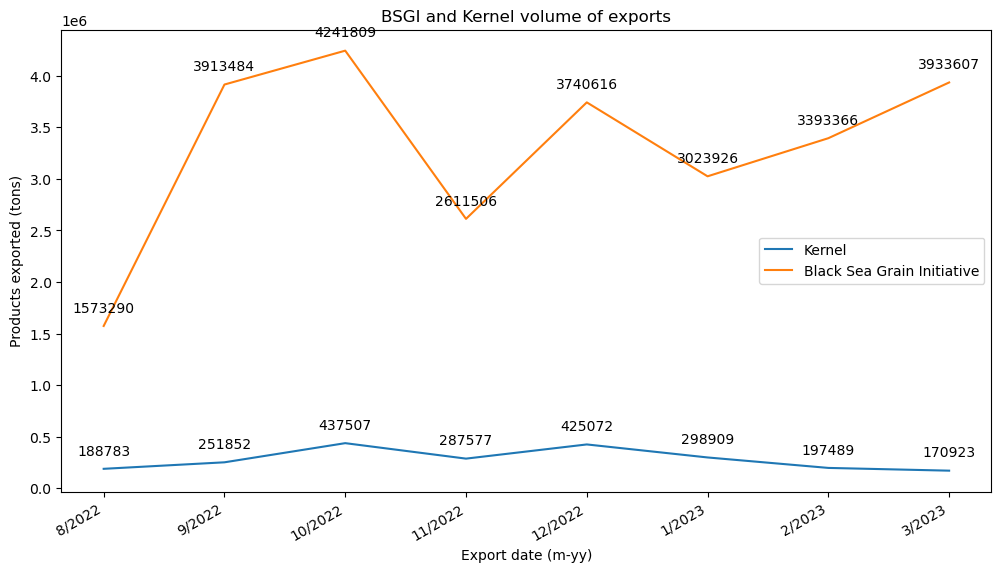

In [32]:
# Plot together
print("IG columns:\n", kernel_g.columns)
print("BSGI columns:\n", outbound_g.columns)
final = kernel_g.merge(outbound_g, on="date", suffixes=("_kernel", "_bsgi"))
plot_line(final["date"], [final["weight_ton_kernel"], final["weight_ton_bsgi"]], ["Kernel", "Black Sea Grain Initiative"], "BSGI and Kernel volume of exports", "Export date (m-yy)", "Products exported (tons)")

In [23]:
# PLOT BY CROP

# First we see the possible product categories based on the BSGI dataset
products = outbound["commodity"].unique()

products_val = ["corn", "soya", "sunflower", "wheat", "sunflower", "barley", "peas", "rapeseed", "sunflower", "vegetable", "soya", "canola", "rapeseed", "sunflower", "mixed", "wheat", "sugar beet"]

d = {}
for i, product in enumerate(products):
    d[product] = products_val[i]

outbound_c = outbound.copy()

outbound_c["product_std"] = outbound_c["commodity"].apply(lambda x: d[x])
print("Outbound data:\n", outbound_c.head())

product_std = set(products_val)

# We create columns for each product
for product in product_std:
    kernel_c[product] = kernel_c["product_deepl"].apply(lambda x: True if product in x.lower() else False)

kernel_c


Outbound data:
        status            vessel_name      imo departure_port country  \
0    Outbound  981       SSI AVENGER  9284544    Chornomorsk   Spain   
1  Outbound +  981       SSI AVENGER  9284544    Chornomorsk  France   
2    Outbound  980  SANTORINI ISLAND  9393618    Chornomorsk   Italy   
3    Outbound  979          EUROSTAR  9546203    Chornomorsk   China   
4    Outbound  978              DIAS  9248904          Odesa   China   

        commodity  weight_ton departure_date inspection_cleared  \
0            Corn       18137     2023-06-14                NaN   
1      Soya beans       28963     2023-06-14                NaN   
2            Corn       45486     2023-06-14                NaN   
3  Sunflower meal       29188     2023-06-14                NaN   
4            Corn       66000     2023-06-14                NaN   

          income_group              flag      world_bank_region  \
0          high-income  Marshall Islands  Europe & Central Asia   
1          hig

,product,hs_code,consignee,consignee_address,shipper,shipper_address,export_date,quantity,weight_kg,invoice_price_uah,...,rapeseed,sugar beet,sunflower,barley,corn,soya,peas,mixed,canola,vegetable
0,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,False,False,True,False,False,False,False,False,False,False
1,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,False,False,True,False,False,False,False,False,False,False
2,СОЛІ ТА ГІДРОКСИДИ АМОНІЮ ЧЕТВЕРТИННІ; ЛЕЦИТИН...,2923200000,NATEEO SRL VIA DELL INNOVAZIONE N 1 36043 CAMI...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23700.0000,4408200.0000,...,False,False,False,False,False,False,False,False,False,False
3,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24380.0000,1025550.0000,...,False,False,True,False,False,False,False,False,False,False
4,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23950.0000,754425.0000,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,TSP TRADING SARL LEBANON JOUNIEH FREM BUILDING,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВ ШЕВЧЕНКА ТА...,NaN,2021-02-25,NaN,25191.9000,768900.6000,...,False,False,True,False,False,False,False,False,False,False
9996,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,ООО СОЙТЭКС 220125 РЕСПУБЛИКА БЕЛАРУСЬ Г МИНСК...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,360350.0000,2948023.3500,...,False,False,True,False,False,False,False,False,False,True
9997,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ АГРОГ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,243700.0000,2089118.2500,...,False,False,True,False,False,False,False,False,False,True
9998,"МАКУХА ТА ІНШІ ТВЕРДІ ВІДХОДИ І ЗАЛИШКИ, ОДЕРЖ...",2306300000,СЗАО АГРОЛИНК РЕСПУБЛИКА БЕЛАРУСЬ 213353 МOГИЛ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,179650.0000,1464866.1000,...,False,False,True,False,False,False,False,False,False,True


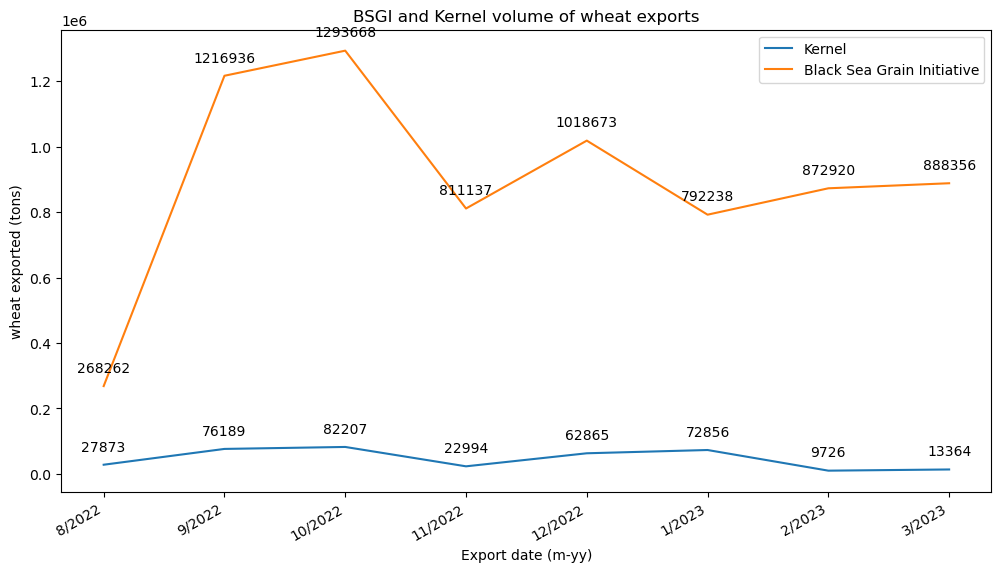

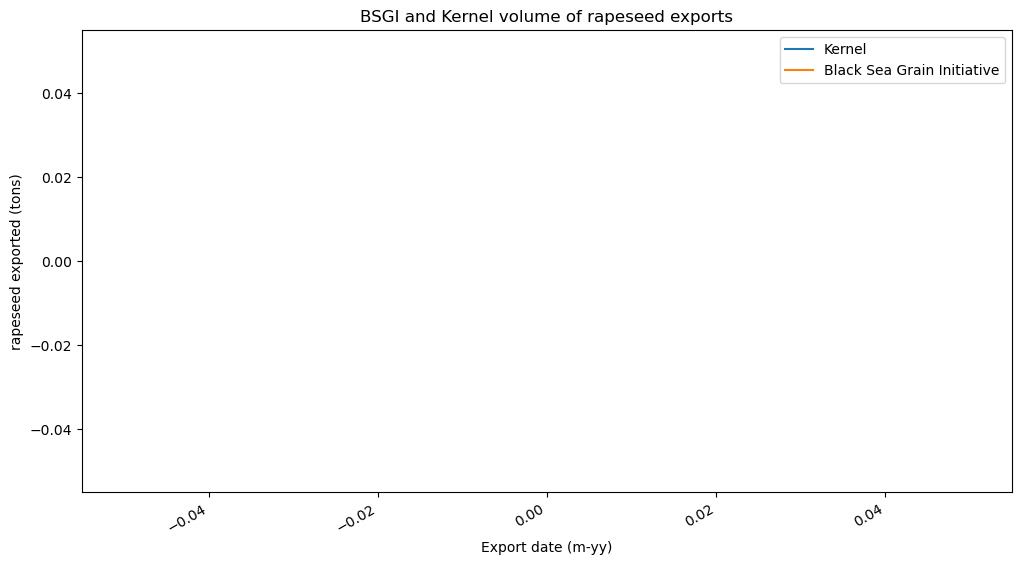

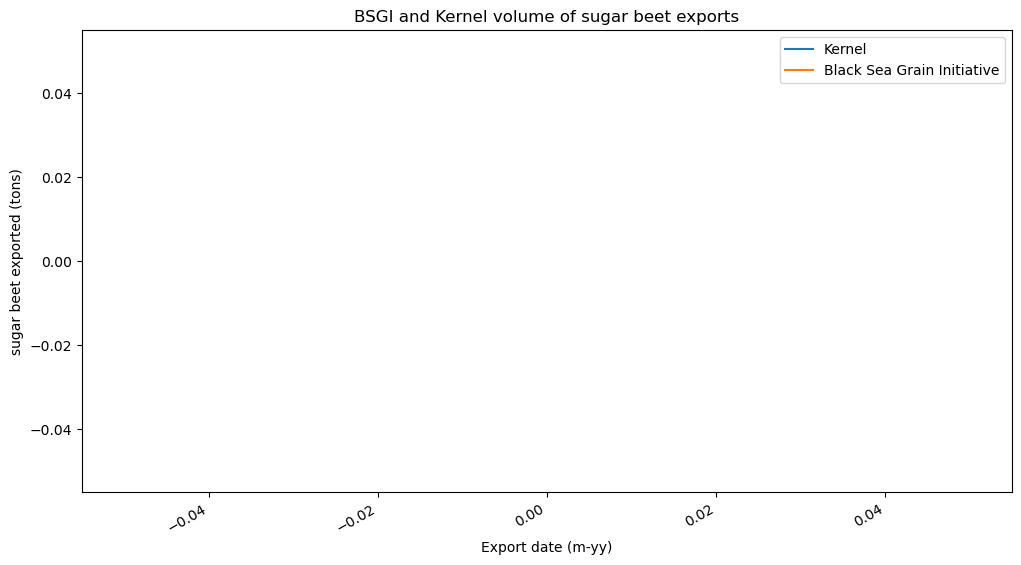

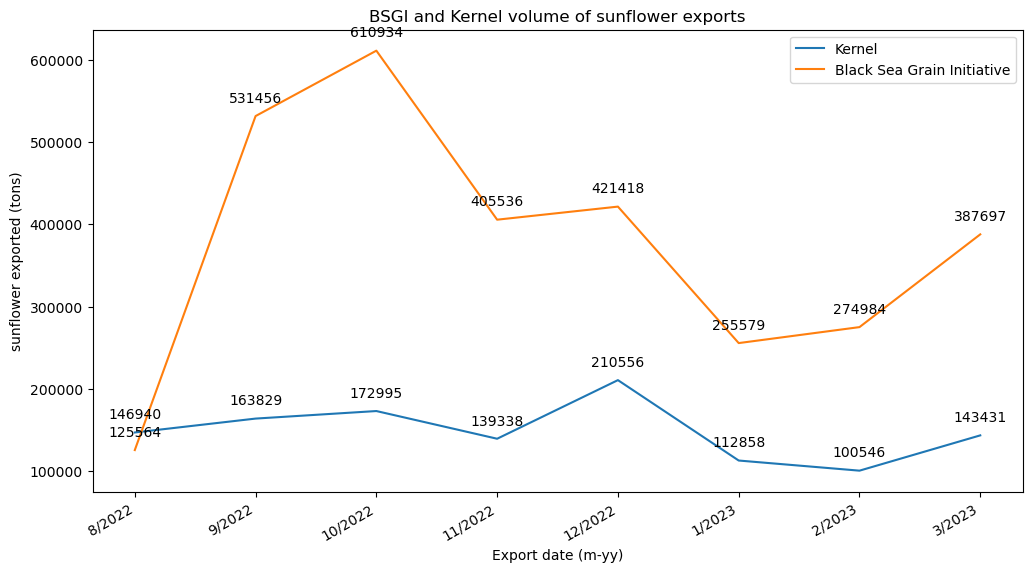

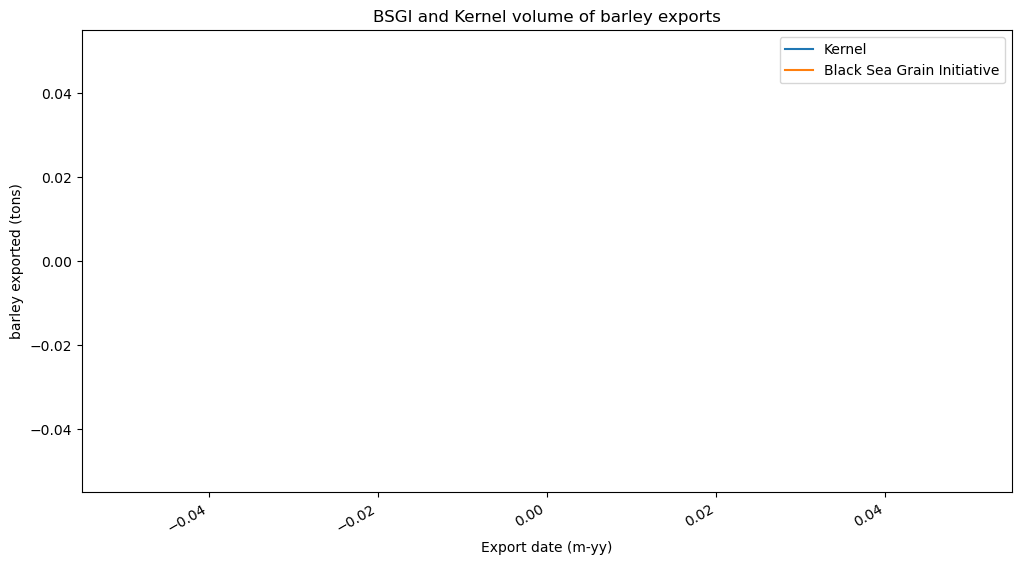

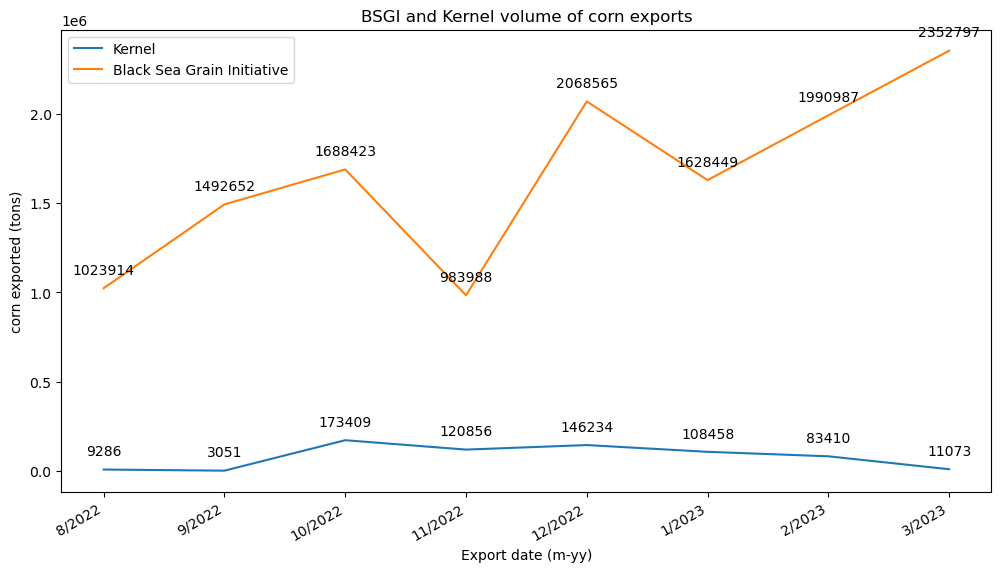

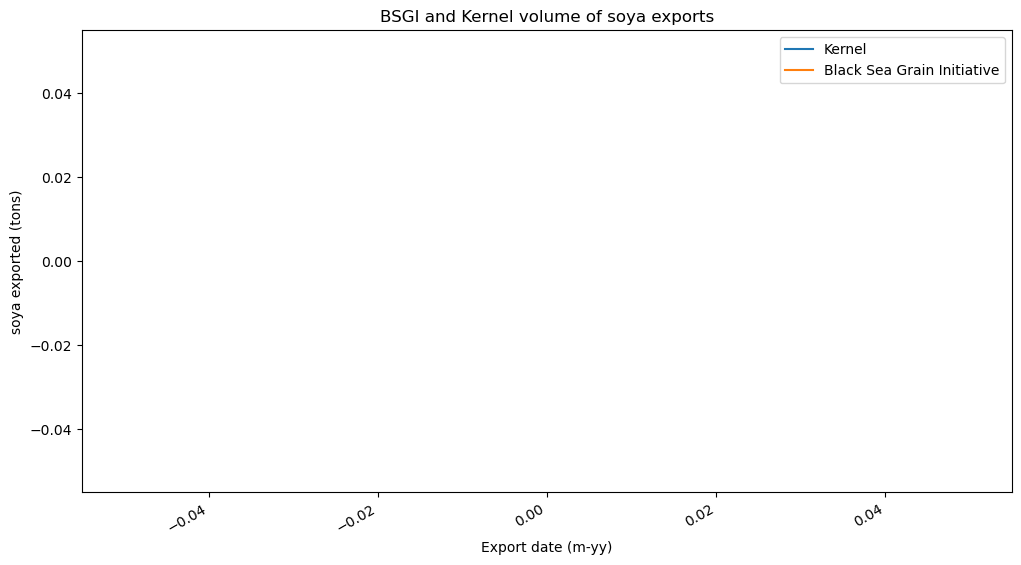

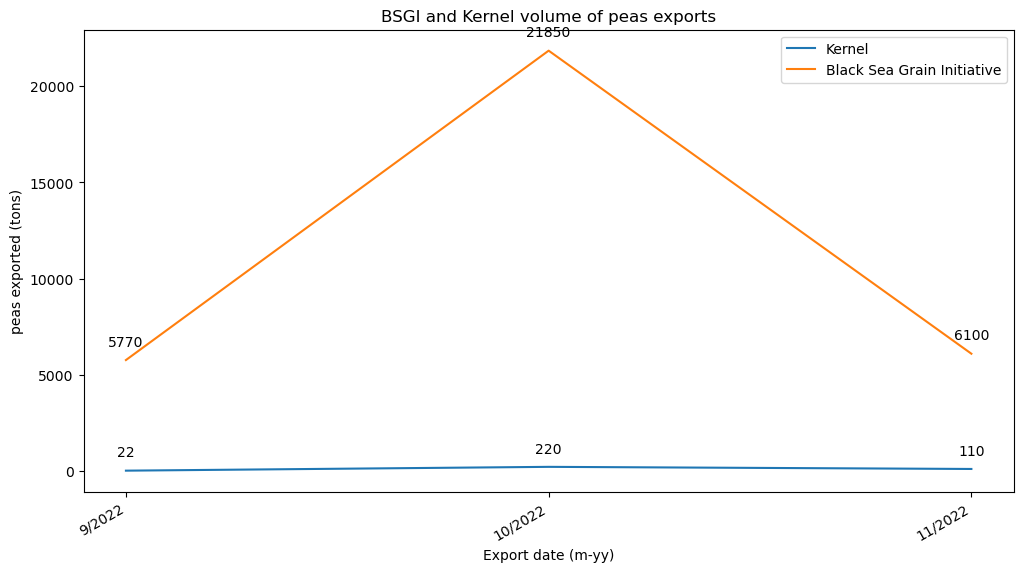

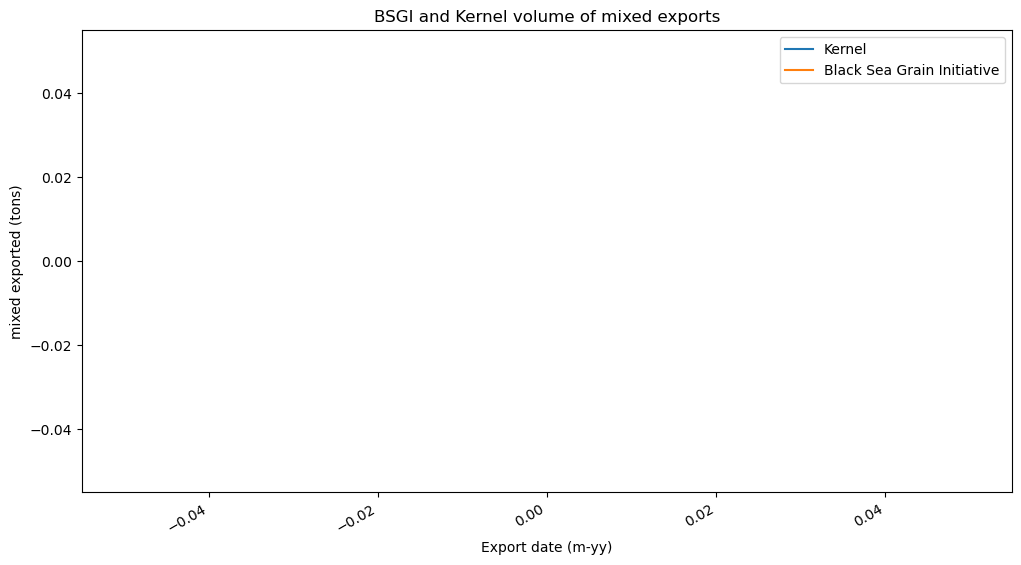

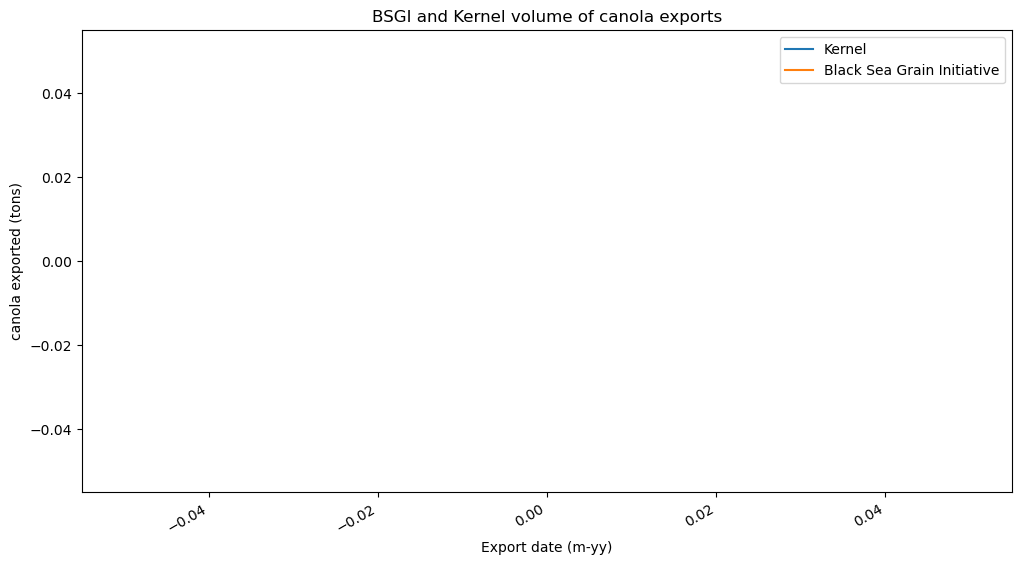

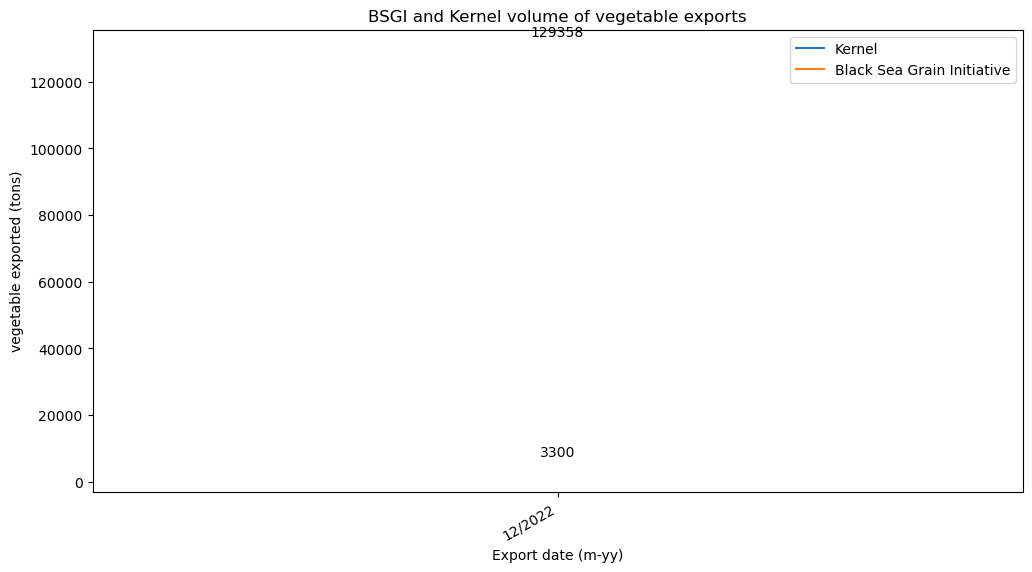

In [24]:
# PLOT CROPS

for crop in product_std:
    plot_crops(crop, kernel_c, outbound_c)

In [25]:
# RECORD MATCHING
print("Kernel:\n", kernel_c["destination_country"].head())
print("BSGI:\n", outbound_c["country"].head())

# Translate country column to English
translate_column(kernel_c, "destination_country", "google", "uk", "en")
kernel_c["destination_country_gt"] = kernel_c["destination_country_gt"].str.lower()

Kernel:
 0       ОМАН
1       ОМАН
2     ІТАЛІЯ
3    СЕНЕГАЛ
4       ОМАН
Name: destination_country, dtype: object
BSGI:
 0     Spain
1    France
2     Italy
3     China
4     China
Name: country, dtype: object


In [26]:
kernel_c = kernel_c.rename(columns={"export_date": "date", "destination_country_gt": "country"})
outbound_c = outbound_c.rename(columns={"departure_date": "date"})
outbound_c["country"] = outbound_c["country"].str.lower()

crop_kernel = kernel_c.loc[kernel_c.loc[:, "sunflower"] == True]
crop_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

crop_kernel.index.name = "kernel_i"
crop_bsgi.index.name = "bsgi_i"

matches = find_matches(crop_kernel, crop_bsgi, ["date"], ["country"], ["date"])
matches = matches.reset_index()[["kernel_i", "bsgi_i"]]
matches
# print(features.loc[[1685, 1687, 1688, 1689, 1690]])

Full matches:
 2135 
                  date  country
kernel_i bsgi_i               
24       146        1   0.0000
25       146        1   0.0000
26       146        1   0.0000
27       146        1   0.0000
29       146        1   0.0000
...               ...      ...
3180     1107       1   0.0000
3181     1107       1   0.0000
3182     1107       1   0.0000
3183     1107       1   0.0000
3184     1107       1   0.0000

[2135 rows x 2 columns]
Number of matches:  41


,kernel_i,bsgi_i
0,1157,447
1,1158,447
2,1600,573
3,1685,607
4,1687,607
5,1688,607
6,1689,607
7,1690,607
8,1786,638
9,1787,638


In [28]:
print("Import Genius:\n", crop_kernel.loc[[1685, 1687, 1688, 1689, 1690], ["date", "country", "product_deepl", "weight_ton"]])
print("BSGI:\n", crop_bsgi.loc[607, ["date", "country", "commodity", "weight_ton"]])

Import Genius:
                date country  \
kernel_i                      
1685     2022-11-15   china   
1687     2022-11-15   china   
1688     2022-11-15   china   
1689     2022-11-15   china   
1690     2022-11-15   china   

                                              product_deepl  weight_ton  
kernel_i                                                                 
1685      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...  10500.0000  
1687      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...   4000.0000  
1688      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...   5000.0000  
1689      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...  10000.0000  
1690      SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...   9850.0000  
BSGI:
 date          2022-11-15 00:00:00
country                     china
commodity          Sunflower meal
weight_ton                  43000
Name: 607, dtype: object


In [29]:
# Now we try merging just exports from Import Genius that only have sunflower in their product name
# First we create a variable that sums the number of products mentioned in the product name
sunflower_kernel = kernel_c.copy()

sunflower_kernel["n_products"] = 0

for product in product_std:
    sunflower_kernel["n_products"] += sunflower_kernel[product]

sunflower_kernel = sunflower_kernel.loc[(sunflower_kernel.loc[:, "sunflower"] == True) & (sunflower_kernel.loc[:, "n_products"] == 1)]
sunflower_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

sunflower_kernel.index.name = "df1_i"
sunflower_bsgi.index.name = "df2_i"

matches = find_matches(sunflower_kernel, sunflower_bsgi, ["date"], ["country"], ["date"])

# Add this to find_matches function later if it turns out to be neccesary 
matches = matches.reset_index()
matches

bsgi_i = matches.groupby("df2_i")["df1_i"].nunique()

unique = matches[matches["df2_i"].isin(bsgi_i[bsgi_i == 1].index)][["df1_i", "df2_i"]].reset_index(drop=True)

full_unique = unique.merge(sunflower_kernel, left_on='df1_i', right_index=True)
full_unique = full_unique.merge(sunflower_bsgi, left_on='df2_i', right_index=True)
full_unique[["df1_i", "df2_i", "date_x", "date_y", "product_deepl", "commodity", "country_x" , "country_y", "weight_ton_x", "weight_ton_y"]]

Full matches:
 1957 
              date  country
df1_i df2_i               
24    146       1   0.0000
25    146       1   0.0000
26    146       1   0.0000
27    146       1   0.0000
29    146       1   0.0000
...           ...      ...
3180  1107      1   0.0000
3181  1107      1   0.0000
3182  1107      1   0.0000
3183  1107      1   0.0000
3184  1107      1   0.0000

[1957 rows x 2 columns]
Number of matches:  39


,df1_i,df2_i,date_x,date_y,product_deepl,commodity,country_x,country_y,weight_ton_x,weight_ton_y
0,1600,573,2022-11-23,2022-11-23,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower seed,france,france,19.8720,40771
1,2012,683,2022-10-25,2022-10-25,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,spain,spain,6300.0000,6300
2,2439,852,2022-09-28,2022-09-28,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower meal,italy,italy,20.0192,5350
3,2538,929,2022-09-19,2022-09-19,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower meal,italy,italy,19.4304,4400
4,2585,961,2022-09-15,2022-09-15,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,italy,italy,20.0192,5750
5,2695,1022,2022-09-06,2022-09-06,"SUNFLOWER, SAFFLOWER OR COTTONSEED OILS AND FR...",Sunflower oil,italy,italy,20.0192,5800


In [30]:
sunflower_kernel = kernel_c.copy()

sunflower_kernel["n_products"] = 0

for product in product_std:
    sunflower_kernel["n_products"] += sunflower_kernel[product]

# print("Products BSGI:\n", product_std)

sunflower_kernel = sunflower_kernel.loc[(sunflower_kernel.loc[:, "sunflower"] == True) & (sunflower_kernel.loc[:, "n_products"] == 1)]
sunflower_bsgi = outbound_c.loc[outbound_c.loc[:, "product_std"] == "sunflower"]

sunflower_kernel = sunflower_kernel[["date", "country", "weight_ton"]].groupby(["date", "country"]).sum().reset_index()

sunflower_kernel.index.name = "df1_i"
sunflower_bsgi.index.name = "df2_i"

matches = find_matches(sunflower_kernel, sunflower_bsgi, ["date"], ["country"], ["date"])

# Add this to find_matches function later if it turns out to be neccesary 
matches = matches.reset_index()
# print("All matches:\n", matches)
bsgi_i = matches.groupby("df2_i")["df1_i"].nunique()
unique = matches[matches["df2_i"].isin(bsgi_i[bsgi_i == 1].index)][["df1_i", "df2_i"]].reset_index(drop=True)

full_unique = unique.merge(sunflower_kernel, left_on='df1_i', right_index=True)
full_unique = full_unique.merge(sunflower_bsgi, left_on='df2_i', right_index=True)
full_unique[["df1_i", "df2_i", "date_x", "date_y", "commodity", "country_x" , "country_y", "weight_ton_x", "weight_ton_y"]]

Full matches:
 669 
              date  country
df1_i df2_i               
1791  1107      1   0.0000
1792  1107      1   0.0000
1793  1107      1   0.0000
1794  1107      1   0.0000
1801  1103      1   0.0000
...           ...      ...
2612  153       1   0.0000
2613  146       1   0.0000
2614  146       1   0.0000
2615  146       1   0.0000
2616  146       1   0.0000

[669 rows x 2 columns]
Number of matches:  12


,df1_i,df2_i,date_x,date_y,commodity,country_x,country_y,weight_ton_x,weight_ton_y
0,1863,1046,2022-09-02,2022-09-02,Sunflower oil,india,india,19000.0000,21000
1,1875,1022,2022-09-06,2022-09-06,Sunflower oil,italy,italy,20.0192,5800
2,1912,961,2022-09-15,2022-09-15,Sunflower oil,italy,italy,20.0192,5750
3,1930,929,2022-09-19,2022-09-19,Sunflower meal,italy,italy,19.4304,4400
4,1948,895,2022-09-23,2022-09-23,Sunflower oil,romania,romania,5723.3380,11950
5,1963,852,2022-09-28,2022-09-28,Sunflower meal,italy,italy,20.0192,5350
6,2069,686,2022-10-25,2022-10-25,Sunflower oil,romania,romania,59.6160,4000
7,2071,683,2022-10-25,2022-10-25,Sunflower oil,spain,spain,6300.0000,6300
8,2105,639,2022-11-04,2022-11-04,Sunflower oil,romania,romania,39.7440,12500
9,2141,607,2022-11-15,2022-11-15,Sunflower meal,china,china,39350.0000,43000
